### CNN

#### Phần A1: Huấn luyện tập Chars74K trên CNN

In [1]:
import shutil
import os
import string, re
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import cv2
import random

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Input

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

In [2]:
import tarfile
import urllib.request

url = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz'
output_path = 'EnglishImg.tgz'

urllib.request.urlretrieve(url, output_path)

with tarfile.open(output_path, 'r:gz') as tar:
    tar.extractall('dataset')

3. Tải tên tệp và chia tập dữ liệu

In [3]:
CLASSES = string.digits + string.ascii_uppercase + string.ascii_lowercase

def load_filenames(datapath, filters=[]):
    filenames = []
    for path, dirs, files in os.walk(datapath):
        if sum(map(lambda f: f in path, filters)) == len(filters):
            filenames += list(map(lambda f: path + '/' + f, files))
    return filenames

def split_dataset(filenames, train_ratio=0.8, val_ratio=0.1):
    np.random.shuffle(filenames)
    train_size = int(len(filenames) * train_ratio)
    val_size = int(len(filenames) * val_ratio)

    train_files = filenames[:train_size]
    val_files = filenames[train_size:train_size + val_size]
    test_files = filenames[train_size + val_size:]

    return train_files, val_files, test_files

def save_filenames_to_file(filenames, filename):
    with open(filename, 'w') as f:
        for file in filenames:
            f.write(file + '\n')

def load_filenames_from_file(filename):
    with open(filename, 'r') as f:
        return [line.strip() for line in f]

def check_class_consistency(filenames):
    classes = set([os.path.basename(os.path.dirname(f)) for f in filenames])
    return len(classes) == len(CLASSES), classes

Kiểm tra tính nhất quán của dữ liệu

In [4]:
filenames = load_filenames('dataset/English/', ['GoodImg', 'Bmp'])
train_files, val_files, test_files = split_dataset(filenames)

save_filenames_to_file(train_files, 'Split_train')
save_filenames_to_file(val_files, 'Split_val')
save_filenames_to_file(test_files, 'Split_test')

train_files = load_filenames_from_file('Split_train')
val_files = load_filenames_from_file('Split_val')
test_files = load_filenames_from_file('Split_test')

train_check, train_classes = check_class_consistency(train_files)
val_check, val_classes = check_class_consistency(val_files)
test_check, test_classes = check_class_consistency(test_files)

if not (train_check and val_check and test_check):
    print("Some datasets are missing classes. Re-distributing data.")
    # Combine all files and re-split until each dataset contains all classes
    all_files = train_files + val_files + test_files
    while not (train_check and val_check and test_check):
        train_files, val_files, test_files = split_dataset(all_files)
        train_check, train_classes = check_class_consistency(train_files)
        val_check, val_classes = check_class_consistency(val_files)
        test_check, test_classes = check_class_consistency(test_files)
    save_filenames_to_file(train_files, 'Split_train')
    save_filenames_to_file(val_files, 'Split_val')
    save_filenames_to_file(test_files, 'Split_test')

Some datasets are missing classes. Re-distributing data.


4. Sao chép các tệp vào file train, test, valid

In [5]:
train_path = "data/train"
val_path = "data/val"
test_path = "data/test"

def copy_files(file_list, dest_dir):
    for filepath in file_list:
        splits = filepath.split('/')
        category = splits[-2]
        filename = splits[-1]
        dest_category_dir = os.path.join(dest_dir, category)
        if not os.path.exists(dest_category_dir):
            os.makedirs(dest_category_dir)
        shutil.copyfile(filepath, os.path.join(dest_category_dir, filename))

with open('Split_train', 'r') as fp:
    train_files = [line.strip() for line in fp]
    copy_files(train_files, train_path)

with open('Split_val', 'r') as fp:
    val_files = [line.strip() for line in fp]
    copy_files(val_files, val_path)

with open('Split_test', 'r') as fp:
    test_files = [line.strip() for line in fp]
    copy_files(test_files, test_path)

5. Chuẩn bị generator

In [6]:
img_width = 32
img_height = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical')

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


6. Tạo và biên dịch mô hình CNN

In [11]:
# Định nghĩa kích thước ảnh đầu vào
img_width, img_height = 32, 32  # Điều chỉnh kích thước phù hợp với ảnh văn bản của bạn

# Định nghĩa mô hình CNN
model = Sequential()

# Sử dụng lớp Input để xác định đầu vào của mô hình
model.add(Input(shape=(img_height, img_width, 1)))

# Thêm các lớp convolutional
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten để chuyển đổi từ tensor sang vector
model.add(Flatten())

# Thêm các lớp fully-connected
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Lớp output với 62 đầu ra tương ứng với 62 lớp
model.add(Dense(62))
model.add(Activation('softmax'))

# Hiển thị tóm tắt mô hình
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_17 (Ba  (None, 16, 16, 64)       

7. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Model_Checkpoint_GS/cnn_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

Steps per epoch: 385
Validation steps: 48


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1897 - loss: 3.6479
Epoch 1: val_accuracy improved from -inf to 0.22727, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/cnn_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.1900 - loss: 3.6463 - val_accuracy: 0.2273 - val_loss: 3.1245 - learning_rate: 0.0010
Epoch 2/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5453 - loss: 1.8916
Epoch 2: val_accuracy improved from 0.22727 to 0.64026, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/cnn_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5454 - loss: 1.8908 - val_accuracy: 0.6403 - val_loss: 1.4299 - learning_rate: 0.0010
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6459 - loss: 1.3654
Epoch 3: val_accuracy improved from 0.64026 to 0.71039, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/cnn_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step -

8. Đánh giá và lưu mô hình

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of constructed CNN performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of constructed CNN performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

# Lưu mô hình hoàn chỉnh theo định dạng mới
model.save("/content/drive/MyDrive/Model_Checkpoint_GS/model_full_cnn.keras")
print("Saved full model to disk in new Keras format")

386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9980 - loss: 0.0248
Summary of constructed CNN performance on Train Data:
 Loss = 0.024114403873682022, Accuracy = 0.9977287650108337 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8361 - loss: 0.6236
Summary of constructed CNN performance on Test Data:
 Loss = 0.6238561868667603, Accuracy = 0.8326848149299622 
--------------------
Saved full model to disk in new Keras format


9. Biểu đồ Loss và Accuracy

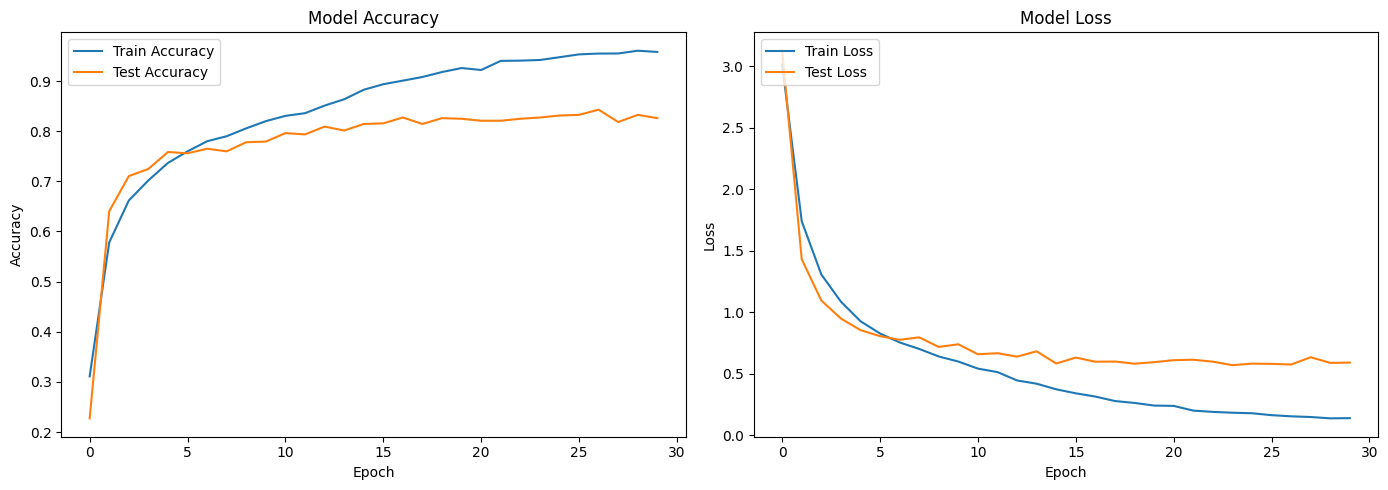

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure và các subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ biểu đồ độ chính xác
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Vẽ biểu đồ loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Test Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### Phần A2: Nhận dạng văn bản trong ảnh từ tập dữ liệu IIIT5K

1. Nhận dạng văn bản

Random ảnh

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_cnn.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

Predicted: FRANK


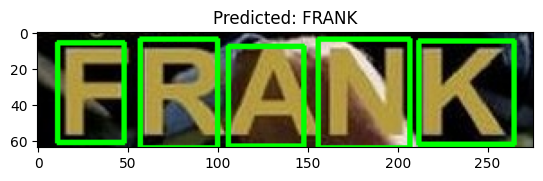

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

output_file = open("recognized_texts.txt", "w")

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = char_img.reshape(1, 32, 32, 1)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


Chỉ đến 1 ảnh

Predicted: DEMoNS


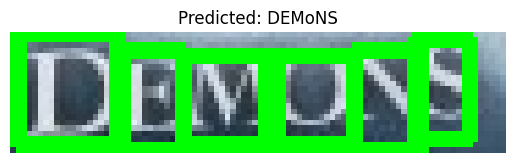

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Đường dẫn đến ảnh cụ thể trong thư mục
specific_image_filename = '65_4.jpg'  # Thay thế bằng tên tệp ảnh bạn muốn sử dụng
img_path = os.path.join(iiit5k_images_test_path, specific_image_filename)
img_file = specific_image_filename

# Kiểm tra nếu ảnh tồn tại
if not os.path.exists(img_path):
    raise FileNotFoundError(f"The image {specific_image_filename} does not exist in the specified directory.")

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = char_img.reshape(1, 32, 32, 1)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# Lưu ảnh đã dự đoán vào một tệp
output_image_path = '/content/recognized_cnn_image.jpg'
cv2.imwrite(output_image_path, img)

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.axis('off')
plt.show()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.33%


In [ ]:
# Tải xuống
from google.colab import files
files.download(output_image_path)

#### Phần A3: Tính độ chính xác của mô hình trên tập test của tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_cnn.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = char_img.reshape(32, 32, 1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)
    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Tính độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")

Độ chính xác của mô hình: 65.37%


### DenseNet

#### Phần B1: Huấn luyện Chars74K bằng DenseNet121

1. Cài đặt và import các thư viện cần thiết

In [ ]:
import shutil
import os
import string
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd

from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from matplotlib import pyplot as plt

2. Chuẩn bị generator với kích thước ảnh 32x32

In [ ]:
img_width = 32
img_height = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


3. Tạo và biên dịch mô hình DenseNet

In [ ]:
input_shape = (img_width, img_height, 1)  # Grayscale ảnh có 1 kênh màu

num_classes = len(CLASSES)

base_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)  # Không tải trọng số từ ImageNet

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

sgd = SGD(learning_rate=0.03)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 1)      │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          3,136 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,144,382 (31.07 MB)

 Trainable params: 8,060,734 (30.75 MB)

 Non-trainable params: 83,648 (326.75 KB)

4. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Model_Checkpoint_GS/densenet_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Steps per epoch: 385
Validation steps: 48
Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.0877 - loss: 3.9755
Epoch 1: val_accuracy improved from -inf to 0.03896, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/densenet_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 250s 294ms/step - accuracy: 0.0879 - loss: 3.9746 - val_accuracy: 0.0390 - val_loss: 6.3382 - learning_rate: 0.0010
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3519 - loss: 2.5246
Epoch 2: val_accuracy improved from 0.03896 to 0.36364, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/densenet_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.3520 - loss: 2.5239 - val_accuracy: 0.3636 - val_loss: 2.7984 - learning_rate: 0.0010
Epoch 3/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5632 - loss: 1.5933
Epoch 3: val_accuracy improved from 0.36364 to 0.53117, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/densenet_b

5. Đánh giá và lưu mô hình

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of constructed DenseNet121 performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of constructed DenseNet121 performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

# Lưu mô hình hoàn chỉnh theo định dạng mới
model.save("/content/drive/MyDrive/Model_Checkpoint_GS/model_full_densenet.keras")
print("Saved full model to disk in new Keras format")

386/386 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9842 - loss: 0.0436
Summary of constructed DenseNet121 performance on Train Data:
 Loss = 0.041136112064123154, Accuracy = 0.985399067401886 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.8233 - loss: 0.9425
Summary of constructed DenseNet121 performance on Test Data:
 Loss = 0.9281830787658691, Accuracy = 0.8261997699737549 
--------------------
Saved full model to disk in new Keras format


6. Biểu đồ Loss và Accuracy

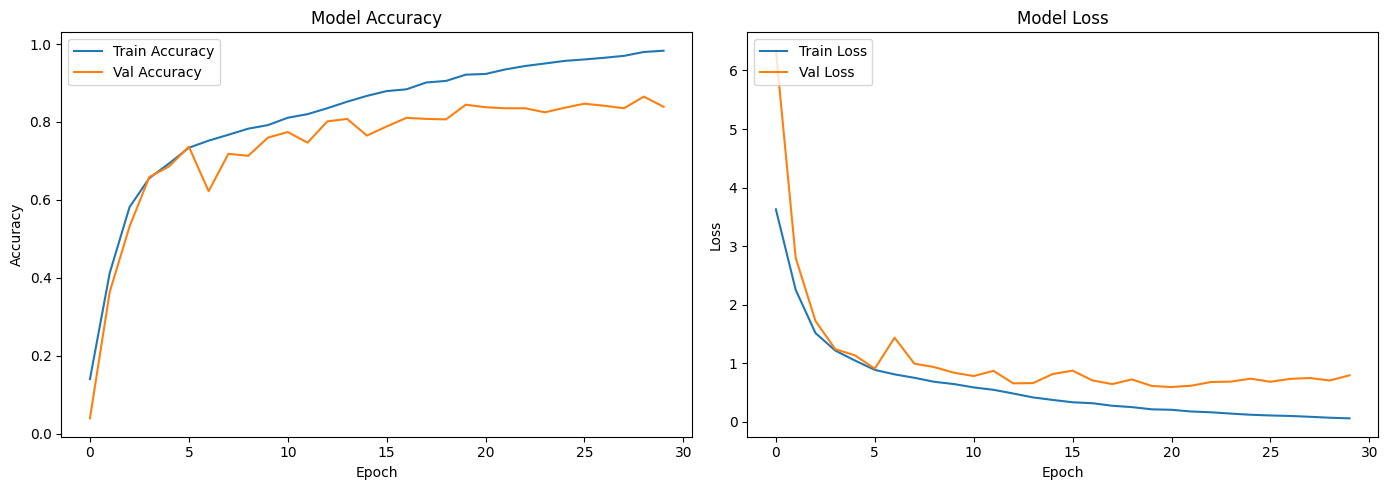

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure và các subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ biểu đồ độ chính xác
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Vẽ biểu đồ loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### Phần B2: Nhận dạng văn bản trong ảnh từ tập dữ liệu IIIT5K

1. Đọc và xử lý ảnh từ tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_densenet.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: only


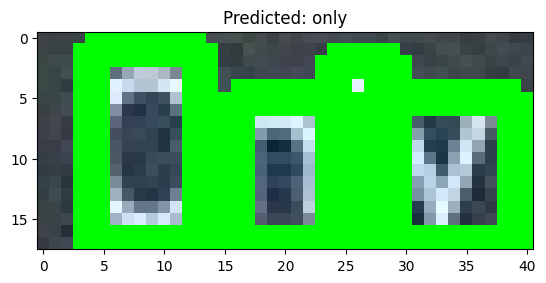

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

output_file = open("recognized_texts.txt", "w")

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))  # Thay đổi kích thước về (32, 32)
    char_img = char_img.reshape(1, 32, 32, 1)  # Đảm bảo ảnh có 1 kênh màu
    char_img = char_img / 255.0

    # Dự đoán ký tự
    prediction = model.predict(char_img)
    predicted_label = np.argmax(prediction)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.00%


Chỉ đến 1 ảnh

Predicted: DEMoNS


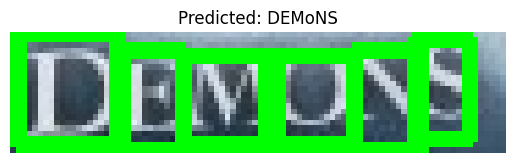

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Đường dẫn đến ảnh cụ thể trong thư mục
specific_image_filename = '65_4.jpg'  # Thay thế bằng tên tệp ảnh bạn muốn sử dụng
img_path = os.path.join(iiit5k_images_test_path, specific_image_filename)
img_file = specific_image_filename

# Kiểm tra nếu ảnh tồn tại
if not os.path.exists(img_path):
    raise FileNotFoundError(f"The image {specific_image_filename} does not exist in the specified directory.")

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = char_img.reshape(1, 32, 32, 1)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# Lưu ảnh đã dự đoán vào một tệp
output_image_path = '/content/recognized_densenet_image.jpg'
cv2.imwrite(output_image_path, img)

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.axis('off')
plt.show()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.33%


#### Phần B3: Đánh giá độ chính xác của mô hình trên tập test của tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_densenet.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = char_img.reshape(32, 32, 1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)
    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy on IIIT5K test dataset: {accuracy * 100:.2f}%")

Accuracy on IIIT5K test dataset: 66.55%


### VGG19

#### Phần C1: Huấn luyện Chars74K bằng VGG19

1. Import các thư viện cần thiết

In [13]:
from tensorflow.keras.applications import VGG19

2. Chuẩn bị generator

In [15]:
# Chuẩn bị generator với kích thước ảnh 32x32
img_width = 32
img_height = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='grayscale',  # Chuyển đổi ảnh sang grayscale
    batch_size=16,
    class_mode='categorical')

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


3. Tạo và biên dịch mô hình VGG19

In [16]:
# Tạo và biên dịch mô hình VGG19
base_model = VGG19(weights=None, include_top=False, input_shape=(img_width, img_height, 1))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Fine-tune các lớp cuối cùng của base_model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Để các lớp còn lại không được huấn luyện
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# In ra mô hình để kiểm tra
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

4. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Model_Checkpoint_GS/vgg19_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASSES)), dtype=tf.float32)
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

Steps per epoch: 385
Validation steps: 48


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0715 - loss: 4.9541
Epoch 1: val_accuracy improved from -inf to 0.04545, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/vgg19_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.0716 - loss: 4.9518 - val_accuracy: 0.0455 - val_loss: 6.6233 - learning_rate: 0.0010
Epoch 2/30
382/386 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1011 - loss: 3.5212
Epoch 2: val_accuracy improved from 0.04545 to 0.04935, saving model to /content/drive/MyDrive/Model_Checkpoint_GS/vgg19_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1012 - loss: 3.5209 - val_accuracy: 0.0494 - val_loss: 87.6340 - learning_rate: 0.0010
Epoch 3/30
384/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1415 - loss: 3.4644
Epoch 3: val_accuracy did not improve from 0.04935
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1416 - loss: 3.4638 - val_accuracy: 0.0195 - val_loss: 45.0782 - lear

5. Đánh giá và lưu mô hình

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of VGG19 performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of VGG19 performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

model.save("/content/drive/MyDrive/Model_Checkpoint_GS/model_full_vgg19.keras")
print("Saved VGG19 model to disk")

386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.0487 - loss: 12.9719
Summary of VGG19 performance on Train Data:
 Loss = 12.957700729370117, Accuracy = 0.05110317841172218 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0378 - loss: 13.9965
Summary of VGG19 performance on Test Data:
 Loss = 13.534746170043945, Accuracy = 0.04150453954935074 
--------------------
Saved VGG19 model to disk


6. Vẽ biểu đồ Loss và Accuracy

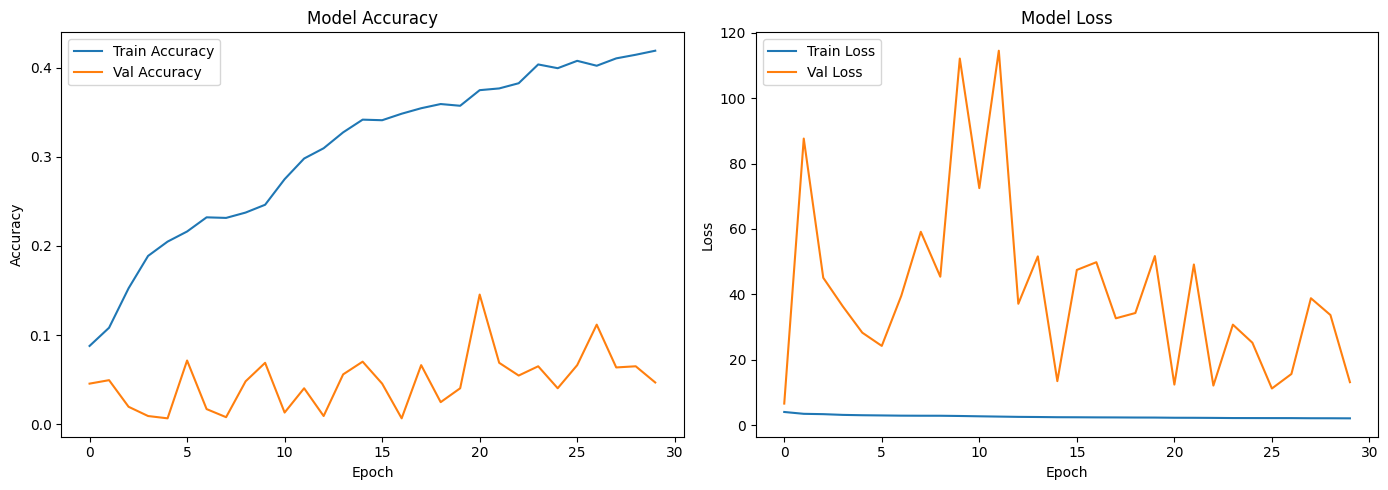

In [ ]:
# Biểu đồ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Phần C2: Nhận dạng văn bản trong ảnh từ tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được train trước đó
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_vgg19.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted: PPPPP


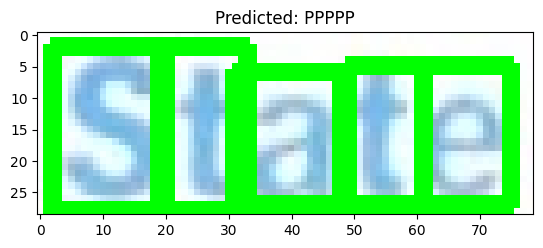

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

output_file = open("recognized_vgg19_texts.txt", "w")

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))  # Thay đổi kích thước về (32, 32)
    char_img = char_img.reshape(1, 32, 32, 1)  # Đảm bảo ảnh có 1 kênh màu
    char_img = char_img / 255.0

    # Dự đoán ký tự
    prediction = model.predict(char_img)
    predicted_label = np.argmax(prediction)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 0.00%


#### Phần C3: Tính độ chính xác trên từng tập dữ liệu

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Model_Checkpoint_GS/model_full_vgg19.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/images/new_test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/drive/MyDrive/Source/IIIT5K_coco/labels/new_test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = char_img.reshape(32, 32, 1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)
    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy on IIIT5K test dataset: {accuracy * 100:.2f}%")

Accuracy on IIIT5K test dataset: 3.17%
